## Messages as state

In [10]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [
    AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(
    f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


In [11]:
from langchain_openai import ChatOpenAI
llm: ChatOpenAI = ChatOpenAI(
    base_url="http://127.0.0.1:1234/v1",
    temperature=0,
    api_key="not-needed"
)
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

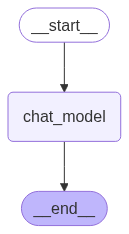

In [12]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}


builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## Reducer filtering

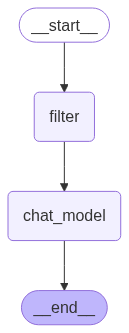

In [13]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import RemoveMessage

def filter_messages(state: MessagesState):
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    # vì có reducer add nơi state nên return về delete_message thì reducer sẽ xóa
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}


builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage(
    "So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage(
    "Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

<think>
Okay, the user mentioned they know about whales but want to learn more about other ocean mammals. Let me start by recalling the main types of marine mammals.

First, there are the baleen whales and toothed whales. Baleen whales like bluefin tuna and humpback whales have baleen plates for filtering food. Toothed whales, such as orcas and sperm whales, use teeth to catch prey. I should explain the difference between them.

Then there's the dolphin family, which includes species like bottlenose dolphins and killer whales. They're known for their intelligence and social structures. Maybe mention their unique 

## Filtering messages

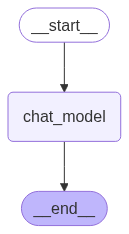

In [15]:
# Node : chỉ lấy tin nhắn gần nhất làm context
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Trim messages

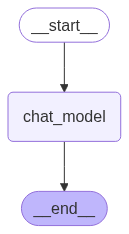

In [16]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
        state["messages"],
        max_tokens=100,
        strategy="last",
        token_counter=llm,
        allow_partial=False,
    )
    return {"messages": [llm.invoke(messages)]}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [20]:
# Example of trimming messages
trim_messages(
    messages,
    max_tokens=100,
    strategy="last",
    token_counter=llm,
    allow_partial=True
)

[AIMessage(content='- Many marine mammals face threats like pollution, overfishing, and climate change.\n- Protecting their habitats (e.g., whale sanctuaries) is crucial for their survival.\n\n---\n\nWould you like to dive deeper into a specific group? For example, how do dolphins use echolocation? Or what’s the role of whales in ocean ecosystems? 😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1163, 'prompt_tokens': 37, 'total_tokens': 1200, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen3-1.7b', 'system_fingerprint': 'qwen3-1.7b', 'id': 'chatcmpl-pn1afzurzcbqxyqhwkt3t', 'finish_reason': 'stop', 'logprobs': None}, id='run--d87e5445-2975-486e-afdf-fcbca2ec03cf-0', usage_metadata={'input_tokens': 37, 'output_tokens': 1163, 'total_tokens': 1200, 'input_token_details': {}, 'output_token_details': {}}),
 HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='